In [ ]:
# 데이터를 더 늘려 2025/01/01 ~ 2025/04/28로 측정하였습니다.

DLinear 와 NLinear 모델 선정 이유  
1. PM10 이라는 단일 변수의 시계열 데이터를 활용  
2. 따라서 복잡한 다변량 모델 필요하지 않음  
3. 따라서 복잡도가 낮고 해석 가능하며 성능이 좋은 경량 모델이 적합하다 판단

In [ ]:
!pip install darts

In [ ]:
# 경고 메시지 및 로깅 비활성화 (깔끔한 출력을 위해)
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

# 필요한 라이브러리들 import
import matplotlib.pyplot as plt  # 그래프 시각화
import numpy as np              # 수치 계산
import pandas as pd             # 데이터 처리
import torch                    # PyTorch 딥러닝 프레임워크
from pytorch_lightning.callbacks.early_stopping import EarlyStopping  # 조기 종료

# Darts 라이브러리 (시계열 예측 전용 라이브러리)
from darts import concatenate
from darts.dataprocessing.transformers.scaler import Scaler
from darts.datasets import ETTh1Dataset, ETTh2Dataset  # 전력 변압기 데이터셋
from darts.metrics import mql                          # 평균 분위 손실
from darts.models import TiDEModel, TSMixerModel      # 예측 모델들
from darts.utils.callbacks import TFMProgressBar      # 진행률 표시바
from darts.utils.likelihood_models.torch import QuantileRegression  # 분위 회귀

In [ ]:
import pandas as pd             # 데이터 처리
import numpy as np              # 수치 계산
import matplotlib.pyplot as plt # 그래프 시각화

# Darts 라이브러리 - 평가 메트릭
from darts.metrics import mape, smape, mae  # MAPE, SMAPE, MAE 메트릭

# Darts 라이브러리 - 데이터 전처리 및 데이터셋
from darts.dataprocessing.transformers import Scaler  # 데이터 정규화
from darts.datasets import WeatherDataset             # 날씨 데이터셋

# Darts 라이브러리 - 예측 모델들
from darts.models import DLinearModel, NLinearModel, TiDEModel

# 확률적 예측을 위한 likelihood 모델
from darts.utils.likelihood_models import GaussianLikelihood

In [ ]:
import pandas as pd

# 파일 업로드
df = pd.read_excel("2024air2.xlsx")

# 상위 5개 데이터 확인
df.head()



,날짜,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
0,2025-04-28,36,15,0.0418,0.0152,0.41,0.0022
1,2025-04-27,23,9,0.0491,0.0081,0.38,0.0017
2,2025-04-26,38,15,0.0396,0.0137,0.42,0.0020
3,2025-04-25,66,34,0.0340,0.0143,0.40,0.0014
4,2025-04-24,53,31,0.0443,0.0123,0.44,0.0016


In [ ]:

df['날짜'] = pd.to_datetime(df['날짜'], format='%Y-%m-%d') # 날짜를 datetime으로 변환

In [ ]:
import pandas as pd
from darts import TimeSeries



In [ ]:
# 데이터 구조 확인
print("PM10 데이터 구조 확인:")
print(series.to_dataframe().head())
print(f"\n데이터 컬럼: {series.columns}")
print(f"데이터 기간: {series.start_time()} ~ {series.end_time()}")
print(f"총 관측값 수: {len(series)}")

PM10 데이터 구조 확인:
component   PM10   이산화질소  일산화탄소
날짜                             
2025-01-01  41.0  0.0334   0.56
2025-01-02  44.0  0.0393   0.61
2025-01-03  26.0  0.0289   0.46
2025-01-04  32.0  0.0314   0.54
2025-01-05  32.0  0.0276   0.56

데이터 컬럼: Index(['PM10', '이산화질소', '일산화탄소'], dtype='object', name='component')
데이터 기간: 2025-01-01 00:00:00 ~ 2025-04-28 00:00:00
총 관측값 수: 118


In [ ]:
print("\n" + "="*60)
print("3. 단변량 시계열 예측 - PM10 예측")
print("="* 60)

# 예측 대상: PM10 (처음 100개 시점 사용)
target = series['PM10'][:100]

# 과거 공변량: 이산화질소 (과거 정보로 활용, 100개 시점까지)
past_cov = series[1][:100]
print("과거 공변량 (이산화질소) 정보:")
print(past_cov.to_dataframe().head())

# 미래 공변량: 일산화탄소 (미래 예측값이라고 가정, 100개 시점까지)
future_cov = series[2][:100]





3. 단변량 시계열 예측 - PM10 예측
과거 공변량 (이산화질소) 정보:
component   PM10   이산화질소  일산화탄소
날짜                             
2025-01-02  44.0  0.0393   0.61


In [ ]:
# 3.1 DLinear 모델 (확률적 예측)
print("\n3.1 DLinear 모델 학습 및 예측")
model_D = DLinearModel(
    input_chunk_length=30,              # 입력 시퀀스 길이
    output_chunk_length=14,             # 출력 시퀀스 길이
    kernel_size=15,                     # 분해 커널 크기
    n_epochs=100,                       # 학습 반복 횟수
    likelihood=GaussianLikelihood(),    # 확률 예측
)


3.1 DLinear 모델 학습 및 예측


In [ ]:
input_len = 30
output_len = 14


In [ ]:
# 4. 모델 정의
model = DLinearModel(
    input_chunk_length=input_len,
    output_chunk_length=output_len,
    kernel_size=15,
    n_epochs=100,
    likelihood=GaussianLikelihood()
)


In [ ]:
df = pd.read_excel("2024air3.xlsx")
df.head()

,날짜,PM10,PM2.5,오 존,이산화질소,일산화탄소,아황산가스
0,2025-06-05,28,14,0.0465,0.0131,0.37,0.0020
1,2025-06-04,31,12,0.0442,0.0117,0.39,0.0018
2,2025-06-03,43,26,0.0415,0.0150,0.47,0.0016
3,2025-06-02,53,37,0.0322,0.0253,0.58,0.0009
4,2025-06-01,46,34,0.0552,0.0117,0.50,0.0013


In [ ]:
forecast = model_D.predict(
    n=14,
    past_covariates=past_cov,
    future_covariates=future_cov,
    num_samples=100
)

<Axes: xlabel='날짜'>

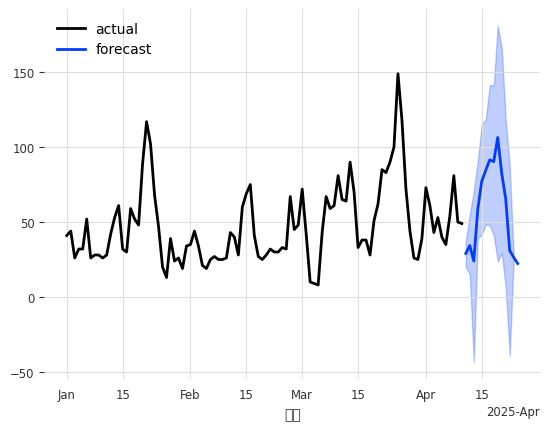

In [ ]:
# 시각화
plt.title("DLinear - PM10")
target.plot(label="actual")
forecast.plot(label="forecast")


In [ ]:
model_N = NLinearModel(
    input_chunk_length=30,     # 과거 42시점의 데이터를 입력으로 사용
    output_chunk_length=14,    # 앞으로 24시점을 예측
    normalize=True,            # 입력 데이터를 정규화해서 학습 안정성 향상
    n_epochs=100               # 100 에포크 동안 학습
)


In [ ]:
target = series['PM10'][:120]              # 학습 구간
past_cov = series['이산화질소'][:120]
future_cov = series['일산화탄소']          # 미래 공변량 전체


In [ ]:
model_N.fit(target, past_covariates=past_cov, future_covariates=future_cov)

Training: |          | 0/? [00:00<?, ?it/s]

NLinearModel(output_chunk_shift=0, shared_weights=False, const_init=True, normalize=True, use_static_covariates=True, input_chunk_length=30, output_chunk_length=14, n_epochs=100)

In [ ]:
model_N = NLinearModel(
    input_chunk_length=30,
    output_chunk_length=14,
    normalize=True,
    n_epochs=100
)

target = series['PM10'][:120]  # 학습 대상
past_cov = series['이산화질소'][:120]
future_cov = series['일산화탄소']

# 학습
model_N.fit(target, past_covariates=past_cov, future_covariates=future_cov)



Training: |          | 0/? [00:00<?, ?it/s]

NLinearModel(output_chunk_shift=0, shared_weights=False, const_init=True, normalize=True, use_static_covariates=True, input_chunk_length=30, output_chunk_length=14, n_epochs=100)

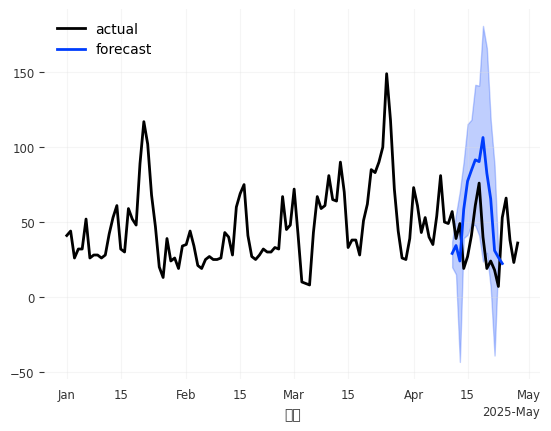

In [ ]:
import matplotlib.pyplot as plt

plt.title("NLinear - PM10")
target.plot(label="actual")
forecast.plot(label="forecast")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()